This notebook covers the concepts underlying design efficiency.

In order to examine the factors that affect efficiency, we need to be able to generate experimental designs that vary in their timing and correlation between regressors. Let's first create a function that can generate such designs for us.

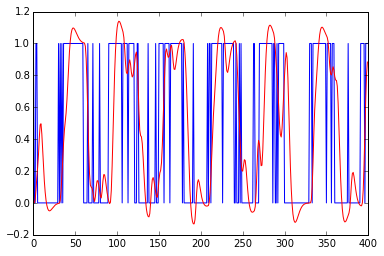

In [2]:
import os
import numpy
%matplotlib inline
from mkdesign import create_design_singlecondition
import matplotlib.pyplot as plt
from spm_hrf import spm_hrf
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor

# the "blockiness" argument controls how block-y the design is
# from 1( pure block) to 0 (pure random)
d,design=create_design_singlecondition(blockiness=0.9)
plt.axis([0,400,-0.2,1.2])
plt.plot(d)

tr=1.0


regressor,_=compute_regressor(design,'spm',numpy.arange(0,len(d)))
plt.plot(regressor,color='red')


Now that we have our design, let's generate some synthetic data.  We will generate AR1 noise to add to the data; this is not a perfect model of the autocorrelation in fMRI, but it's at least a start towards realistic noise.


In [3]:
from statsmodels.tsa.arima_process import arma_generate_sample

ar1_noise=arma_generate_sample([1,0.3],[1,0.],len(regressor))
beta=4
y=regressor.T*beta + ar1_noise
print y.shape

(1, 400)


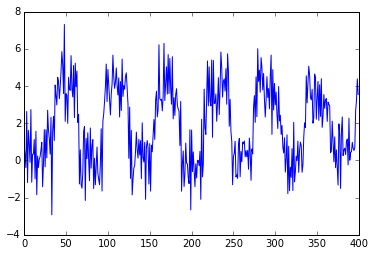

In [31]:
plt.plot(y.T)

Now let's fit the general linear model to these data. We will ignore serial autocorrelation for now.

(-0.5, 1.5, 400.0, -50.0)

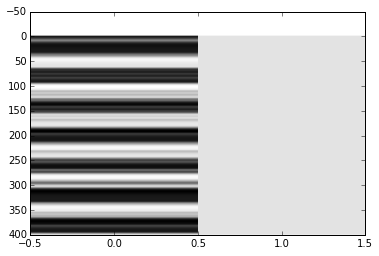

In [4]:
X=numpy.vstack((regressor.T,numpy.ones(y.shape))).T
plt.imshow(X,interpolation='nearest',cmap='gray')
plt.axis('auto')

(400, 2)


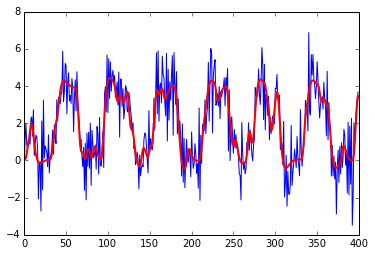

In [5]:
beta_hat=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(y.T)
y_est=X.dot(beta_hat)
plt.plot(y.T,color='blue')
plt.plot(y_est,color='red',linewidth=2)
print X.shape

Now let's make a function to repeatedly generate data and fit the model.

In [8]:
def generate_and_fit(X,beta=[4,10]):
    ar1_noise=arma_generate_sample([1,0.3],[1,0.],X.shape[0])
    y=X.dot(beta) + ar1_noise.T
    beta_hat=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    resid=y - X.dot(beta_hat)
    sigma2_hat=resid.dot(resid)/(X.shape[0] - X.shape[1] - 1)
    return beta_hat,sigma2_hat
    

Now let's write a simulation that creates datasets with varying levels of blockiness, runs the previous function 1000 times for each level, and computes the variability of the estimates

In [25]:
nruns=1000
blockiness_vals=numpy.arange(0,1.1,0.1)
stdvals_blockiness=numpy.zeros((2,len(blockiness_vals)))
meansigmahat_blockiness=numpy.zeros(len(blockiness_vals))

for b in range(len(blockiness_vals)):
    beta_hats=numpy.zeros((2,nruns))
    sigma_hats=numpy.zeros(nruns)
    
    for i in range(nruns):
        d_sim,design_sim=create_design_singlecondition(blockiness=blockiness_vals[b])
        regressor_sim,_=compute_regressor(design_sim,'spm',numpy.arange(0,len(d_sim)))
        X=numpy.vstack((regressor_sim.T,numpy.ones(y.shape))).T
        beta_hats[:,i],sigma_hats[i]=generate_and_fit(X)
    stdvals_blockiness[:,b]=numpy.std(beta_hats,1)
    meansigmahat_blockiness[b]=numpy.mean(sigma_hats)

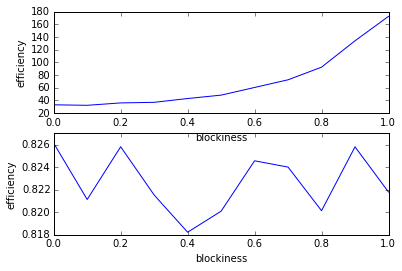

In [26]:
plt.subplot(211)
plt.plot(blockiness_vals,1./stdvals_blockiness[0,:]**2)
plt.xlabel('blockiness')
plt.ylabel('efficiency')

plt.subplot(212)
plt.plot(blockiness_vals,1./meansigmahat_blockiness**2)
plt.xlabel('blockiness')
plt.ylabel('efficiency')



Now let's do a similar simulation looking at the effects of varying block length between 10 seconds and 120 seconds (in steps of 10)

In [129]:
nruns=2500
blocklenvals=numpy.arange(10,120,5)
stdvals_blocklen=numpy.zeros((2,len(blocklenvals)))

for b in range(len(blocklenvals)):
    beta_hats=numpy.zeros((2,nruns))
    for i in range(nruns):
        d_sim,design_sim=create_design_singlecondition(blocklength=blocklenvals[b],blockiness=1.)
        regressor_sim,_=compute_regressor(design_sim,'spm',numpy.arange(0,len(d_sim)))
        X=numpy.vstack((regressor_sim.T,numpy.ones(y.shape))).T
        beta_hats[:,i]=generate_and_fit(X)
    stdvals_blocklen[:,b]=numpy.std(beta_hats,1)

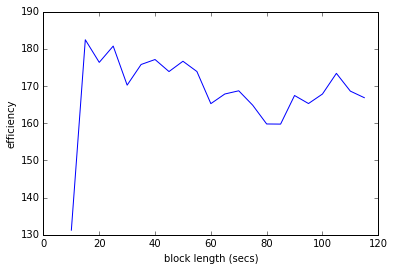

In [130]:
plt.plot(blocklenvals,1./stdvals_blocklen[0,:]**2)
plt.xlabel('block length (secs)')
plt.ylabel('efficiency')


Now let's look at the effects of correlation between regressors. We first need to create a function to generate a design with two conditions where we can control the correlation between them.

In [107]:
#from mkdesign import create_design_twocondition
def create_design_twocondition(deslength=400,correlation=0.0,density=0.5,blocklength=30):
    """
    create a new design with two conditions
    return a set of (onset, duration, amplitude) triples for each condition
    """
    offset=0
    design=numpy.zeros(deslength)
    nevents=round(deslength*density)
    nblocks=(deslength*density)/blocklength
    baselength=(deslength*(1.-density))/nblocks
    blockstarts=numpy.arange(offset,deslength,blocklength+baselength)
    for b in blockstarts:
        design[b:b+blocklength:2]=1
        design[b+1:b+blocklength:2]=2
        

    if correlation<1.0:
        # add stochastic design by flipping trials into rest periods
        for i in range(int(nevents*(1. - correlation))):
            events=numpy.where(design>0)[0]
            numpy.random.shuffle(events)
            nulls=numpy.where(design==0)[0]
            numpy.random.shuffle(nulls)
            design[nulls[0]]=design[events[0]]
            design[events[0]]=0

    onsets1=numpy.where(design==1)[0]
    durations1=numpy.ones(onsets1.shape)
    amplitudes1=numpy.ones(onsets1.shape)
    onsets2=numpy.where(design==2)[0]
    durations2=numpy.ones(onsets2.shape)
    amplitudes2=numpy.ones(onsets2.shape)
    return design,(onsets1,durations1,amplitudes1),(onsets2,durations2,amplitudes2)


d,des1,des2=create_design_twocondition(correlation=1.0)
regressor1,_=compute_regressor(des1,'spm',numpy.arange(0,d.shape[0]))
regressor2,_=compute_regressor(des2,'spm',numpy.arange(0,d.shape[0]))

X=numpy.vstack((regressor1.T,regressor2.T,numpy.ones(y.shape))).T

In [125]:
nruns=500
corr_vals=numpy.arange(0,1.1,0.1)
stdvals_corr=numpy.zeros((3,len(corr_vals)))
corrvals=numpy.zeros(len(corr_vals))
for b in range(len(corr_vals)):
    beta_hats=numpy.zeros((3,nruns))
    corrs=numpy.zeros(nruns)
    for i in range(nruns):
        d_sim,des1_sim,des2_sim=create_design_twocondition(correlation=corr_vals[b])
        regressor1_sim,_=compute_regressor(des1_sim,'spm',numpy.arange(0,d_sim.shape[0]))
        regressor2_sim,_=compute_regressor(des2_sim,'spm',numpy.arange(0,d_sim.shape[0]))
        X=numpy.vstack((regressor1_sim.T,regressor2_sim.T,numpy.ones(y.shape))).T
        beta_hats[:,i]=generate_and_fit(X,[3,5,10])
        corrs[i]=numpy.corrcoef(X.T)[0,1]
    stdvals_corr[:,b]=numpy.std(beta_hats,1)
    corrvals[b]=numpy.mean(corrs)

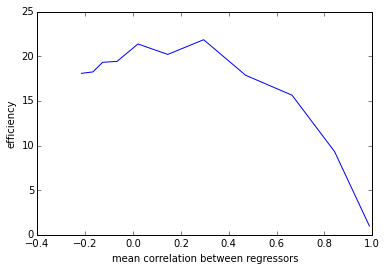

In [126]:
plt.plot(corrvals,1./stdvals_corr[0,:]**2)
plt.xlabel('mean correlation between regressors')
plt.ylabel('efficiency')


Now let's look at efficiency of estimation of the shape of the HRF, rather than detection of the activation effect.  This requires that we use a finite impulse response (FIR) model.

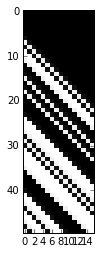

In [137]:
d,design=create_design_singlecondition(blockiness=0.0)
regressor,_=compute_regressor(design,'fir',numpy.arange(0,len(d)),fir_delays=numpy.arange(0,16))
plt.imshow(regressor[:50,:],interpolation='nearest',cmap='gray')


Now let's simulate the FIR model, and estimate the variance of the fits.

In [ ]:
nruns=100
blockiness_vals=numpy.arange(0,1.1,0.1)
stdvals_blockiness=numpy.zeros((2,len(blockiness_vals)))

for b in range(len(blockiness_vals)):
    beta_hats=numpy.zeros((2,nruns))
    for i in range(nruns):
        d_sim,design_sim=create_design_singlecondition(blockiness=blockiness_vals[b])
        regressor_sim,_=compute_regressor(design_sim,'spm',numpy.arange(0,len(d_sim)))
        X=numpy.vstack((regressor_sim.T,numpy.ones(y.shape))).T
        beta_hats[:,i]=generate_and_fit(X)
    stdvals_blockiness[:,b]=numpy.std(beta_hats,1)